In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

(2084L, 2084L, 3L)


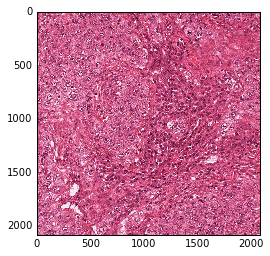

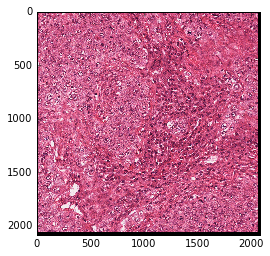

In [3]:
# Let's try to reconsitute an image from patches...
import os
imfile = 'A00_01.bmp'
patchesdir = 'e:/data/MITOS12/train/patches'
imsdir = 'e:/data/MITOS12/train/'

im = plt.imread(os.path.join(imsdir,imfile))
print(im.shape)
classes = np.zeros(im.shape) # channels : class0, class1, nPredictions
    
patches = [f for f in os.listdir(patchesdir) if f.find(imfile) >= 0]
for p in patches:
    y = int(p[11:15])*30
    patch = np.load(os.path.join(patchesdir,p))
    for x in range(64):
        classes[y:y+167,x*30:(x*30)+167,:] = patch[x]

plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(classes.astype('uint8'))
plt.show()

(0.0, 1.0, 0.00079805556271897026, 0.0015948383558164437)
(0.01, 0.99942296595499136, 0.0068512522720485126, 0.013609210575425239)
(0.02, 0.99596076168493941, 0.0098967322435077783, 0.01959871461500903)
(0.03, 0.9930755914598961, 0.011968552125096057, 0.023652049626700287)
(0.04, 0.99105597230236586, 0.013577558094951994, 0.02678811652635724)
(0.05, 0.98817080207732255, 0.014919391724420321, 0.029394978393618071)
(0.06, 0.98355452971725332, 0.016076776156004623, 0.031636436191192101)
(0.07, 0.98211194460473172, 0.017159506790204362, 0.033729686880697579)
(0.08, 0.98124639353721865, 0.018178999807573069, 0.035696667541327734)
(0.09, 0.97951529140219273, 0.019100181718960094, 0.037469717956217265)
(0.1, 0.97576457010963646, 0.019958454311545453, 0.039116806810164363)
(0.11, 0.97287939988459315, 0.020777236233232486, 0.040685573634010826)
(0.12, 0.97028274668205428, 0.021556725018749157, 0.042176418578693566)
(0.13, 0.96826312752452393, 0.02232288361636036, 0.043639673612691401)
(0.14, 0.

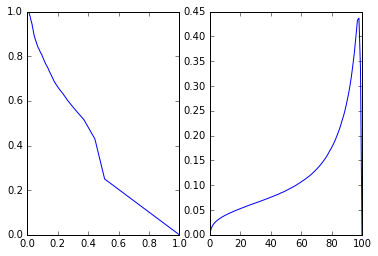

In [5]:
import csv
def get_mask(super_file):
    mask = np.zeros((2084,2084))
    with open(super_file) as f:
        reader = csv.reader(f, delimiter=',')
        mitosis_raw = [np.array(row).astype('int') for row in reader]
        mitosis_coord = [np.vstack([m[::2], m[1::2]]) for m in mitosis_raw]
        for c in mitosis_coord:
            mask[c[1],c[0]] = 1
        return mask
    return None

clf_name="resnet_deep_5"
Pim = np.load('e:/data/tf_checkpoint/%s.ckpt.A00_00.bmp.npy'%clf_name)
im = plt.imread('e:/data/MITOS12/test/A00_00.bmp')
T_mask = get_mask('e:/data/MITOS12/test/A00_00.csv')
ROC = np.zeros((101,2))
Fmeasures = []

for t in range(101):
    thresh = 0.+t/100.
    P_mask = Pim[:,:]>= thresh
    TP = P_mask*T_mask
    FP = P_mask*(1-T_mask)
    
    #TPR = TP.sum()/T_mask.sum()
    #FPR = FP.sum()/((1-T_mask).sum())

    #ROC[t,0] = TPR
    #ROC[t,1] = FPR
    
    recall = TP.sum()/T_mask.sum()
    precision = TP.sum()*1./(TP.sum()+FP.sum()) if (TP.sum()+FP.sum()) > 0 else 1.

    ROC[t,0] = recall
    ROC[t,1] = precision
    Fmeasure = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.
    Fmeasures += [Fmeasure]
    
    #print(thresh, TPR, FPR)
    print(thresh, recall, precision, Fmeasure)

plt.figure()
plt.subplot(1,2,1)
plt.plot(ROC[:,1], ROC[:,0], 'b-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.subplot(1,2,2)
plt.plot(range(101), Fmeasures, 'b-')
plt.show()

(0.25014425851125216, 0.00019287536380164946)


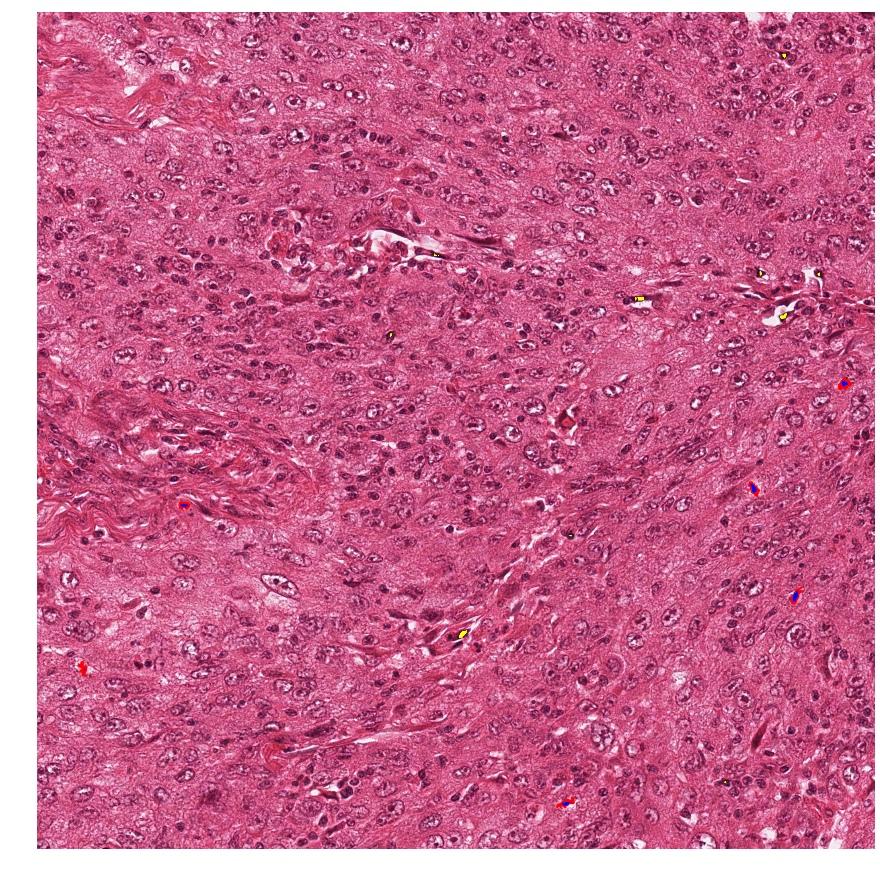

In [6]:
im_res = im.copy()
P_mask = Pim[:,:]>=0.99
TP_mask = (P_mask*T_mask)>0
FP_mask = (P_mask*(1-T_mask))>0
FN_mask = ((1-P_mask)*(T_mask))>0
TPR = TP_mask.sum()/T_mask.sum()
FPR = FP_mask.sum()/((1-T_mask).sum())
print(TPR,FPR)
im_res[TP_mask,:] = 0
im_res[TP_mask,2] = 255  # Blue = TP
im_res[FP_mask,:] = 255
im_res[FP_mask,2] = 0    # Yellow = FP
im_res[FN_mask,:] = 0
im_res[FN_mask,0] = 255  # Red = FN
plt.figure(figsize=(15,15))
plt.imshow(im_res)
plt.axis('off')
plt.show()

In [16]:
from skimage.measure import label, regionprops
def dist(a,b,r):
    return np.sqrt(((a*r-b*r)**2).sum())

def get_raw_measure(GT, P):
    true_centroids = [r.centroid for r in regionprops(label(GT))]
    clf_centroids = [r.centroid for r in regionprops(label(P))]
    HM = np.zeros((len(true_centroids),len(clf_centroids)))

    for i,tc in enumerate(true_centroids):
        for j,cc in enumerate(clf_centroids):
            if dist(np.array(tc),np.array(cc),0.2456) < 5.: HM[i,j] += 1
    
    TP = (HM.sum(axis=1)>0).sum()
    FN = (HM.sum(axis=1)==0).sum()
    FP = (HM.sum(axis=0)==0).sum()
    return TP,FP,FN

imfiles = ['A00_00', 'A00_08', 'A01_04', 'A01_06', 'A01_09', 'A02_00', 'A02_01', 'A02_03', 'A02_07', 'A03_00', 'A03_01', 
           'A03_04', 'A04_03', 'A04_07', 'A04_09']
thresh = 0.75#0.48
TP = 0
FP = 0
FN = 0
for imfile in imfiles:
    Pim = np.load('e:/data/tf_checkpoint/%s.ckpt.%s.bmp.npy'%(clf_name,imfile))
    P_mask = Pim[:,:]>thresh
    
    # Post-processing : removing the really small stuff
    labels = label(P_mask)
    objects = regionprops(labels)
    for obj in objects:
        if obj.area < 15:
            P_mask[labels==obj.label] = 0
    
    T_mask = get_mask('e:/data/MITOS12/test/%s.csv'%imfile)
    meas = get_raw_measure(T_mask, P_mask)
    TP += meas[0]
    FP += meas[1]
    FN += meas[2]
    print(meas,TP,FP,FN)

recall = TP*1./(TP+FN)
precision = TP*1./(TP+FP)
Fmeasure = 2*(precision*recall)/(precision+recall)

print(recall,precision,Fmeasure)

((5, 8, 1), 5, 8, 1)
((3, 1, 0), 8, 9, 1)
((6, 4, 9), 14, 13, 10)
((4, 8, 0), 18, 21, 10)
((9, 3, 3), 27, 24, 13)
((2, 0, 2), 29, 24, 15)
((1, 0, 1), 30, 24, 16)
((0, 6, 1), 30, 30, 17)
((2, 3, 2), 32, 33, 19)
((11, 8, 8), 43, 41, 27)
((7, 2, 3), 50, 43, 30)
((14, 5, 0), 64, 48, 30)
((8, 3, 6), 72, 51, 36)
((5, 7, 0), 77, 58, 36)
((5, 5, 0), 82, 63, 36)
(0.69491525423728817, 0.56551724137931036, 0.62357414448669202)


**Code for the interpretation of results from mitos12_resnet.py, where the output is already a full 2084x2084 image.**

In [5]:
import numpy as np
import os
import csv
from matplotlib import pyplot as plt
%matplotlib inline

def get_mask(super_file):
    mask = np.zeros((2084,2084))
    with open(super_file) as f:
        reader = csv.reader(f, delimiter=',')
        mitosis_raw = [np.array(row).astype('int') for row in reader]
        mitosis_coord = [np.vstack([m[::2], m[1::2]]) for m in mitosis_raw]
        for c in mitosis_coord:
            mask[c[1],c[0]] = 1
        return mask
    return None

path_to_results = "e:/data/MITOS12/results"
path_to_test = "e:/data/MITOS12/test"

test_images = [f[:-4] for f in os.listdir(path_to_test) if f.find('.bmp') >= 0]
clf_name = 'mitos12_resnet_7_softmax_logits'#'mitos12_resnet_7_from_sd_bigdataset'#'mitos12_resnet_7_from_sd'#'mitos12_resnet_13_from_sd'#'mitos12_resnet_from_sd'
#files = [os.path.join(path_to_results, f) for f in os.listdir(path_to_results) if f.find(clf_name) >= 0 and f.find('.npy') >= 0]

0.0 1.0 0.000798055562719 0.00159483835582
0.01 0.628101557992 0.00787535451757 0.0155556667072
0.02 0.626947489902 0.0108673364773 0.0213643491641
0.03 0.625504904789 0.0134509672536 0.0263356089502
0.04 0.622908251587 0.0159054073965 0.0310187779262
0.05 0.620311598384 0.0183034802152 0.035557760688
0.06 0.616272360069 0.020607615942 0.0398816247654
0.07 0.614541257934 0.0228638900816 0.0440875126777
0.08 0.611367570687 0.0248758555111 0.04780651784
0.09 0.610790536642 0.0269681528662 0.0516555645024
0.1 0.607616849394 0.0288457587421 0.055076822491
0.11 0.605885747259 0.0308003696044 0.0586207377839
0.12 0.603577611079 0.0327350681459 0.0621020290027
0.13 0.600692440854 0.0346861255498 0.0655851315168
0.14 0.598384304674 0.0367873993402 0.0693135485596
0.15 0.596941719561 0.0390266905593 0.0732635753616
0.16 0.594633583381 0.04126291343 0.0771707791965
0.17 0.592036930179 0.0434948492942 0.0810362530606
0.18 0.589151759954 0.0458022116053 0.0849965660055
0.19 0.587709174841 0.048346

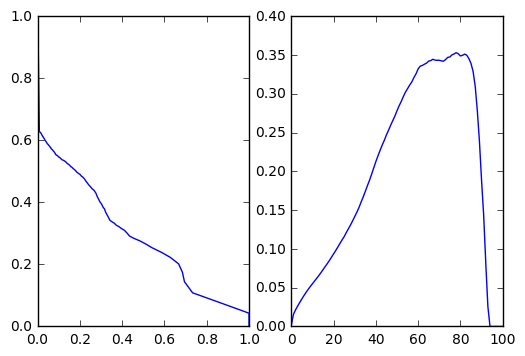

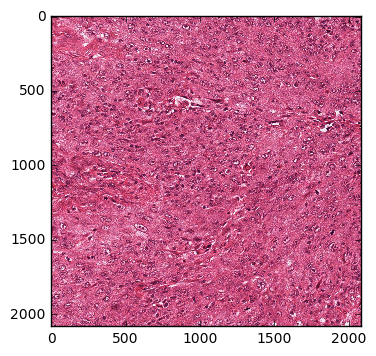

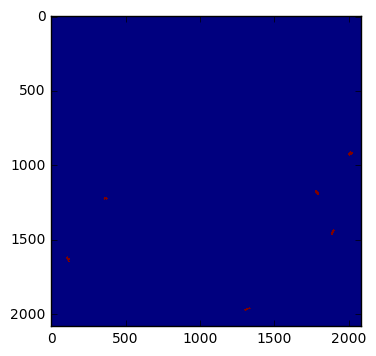

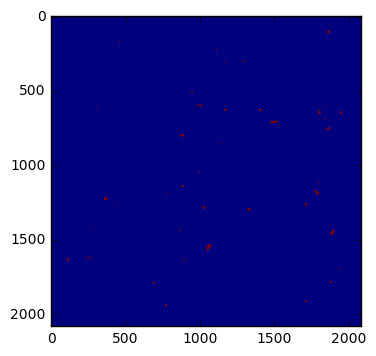

In [6]:
for f in test_images:
    im = plt.imread(os.path.join(path_to_test, "%s.bmp"%f))
    mask = get_mask(os.path.join(path_to_test, "%s.csv"%f))
    res = np.load(os.path.join(path_to_results, "result_%s_%s.bmp.npy"%(clf_name,f)))
    
    ROC = np.zeros((101,2))
    Fmeasures = []

    for t in range(101):
        thresh = 0.+t/100.
        P_mask = res[:,:]>= thresh
        TP = P_mask*mask
        FP = P_mask*(1-mask)

        recall = TP.sum()/mask.sum()
        precision = TP.sum()*1./(TP.sum()+FP.sum()) if (TP.sum()+FP.sum()) > 0 else 1.

        ROC[t,0] = recall
        ROC[t,1] = precision
        Fmeasure = 2*(precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.
        Fmeasures += [Fmeasure]

        print(thresh, recall, precision, Fmeasure)

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(ROC[:,1], ROC[:,0], 'b-')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.subplot(1,2,2)
    plt.plot(range(101), Fmeasures, 'b-')
    plt.figure()
    plt.imshow(im)
    plt.figure()
    plt.imshow(mask)
    plt.figure()
    plt.imshow(res>0.5)
    
    break

In [9]:
from skimage.measure import label, regionprops
def dist(a,b,r):
    return np.sqrt(((a*r-b*r)**2).sum())

def get_raw_measure(GT, P):
    true_centroids = [r.centroid for r in regionprops(label(GT))]
    clf_centroids = [r.centroid for r in regionprops(label(P))]
    HM = np.zeros((len(true_centroids),len(clf_centroids)))

    for i,tc in enumerate(true_centroids):
        for j,cc in enumerate(clf_centroids):
            if dist(np.array(tc),np.array(cc),0.2456) < 5.: HM[i,j] += 1
    
    TP = (HM.sum(axis=1)>0).sum()
    FN = (HM.sum(axis=1)==0).sum()
    FP = (HM.sum(axis=0)==0).sum()
    return TP,FP,FN

thresh = 0.5
TP = 0
FP = 0
FN = 0
for f in test_images:
    im = plt.imread(os.path.join(path_to_test, "%s.bmp"%f))
    mask = get_mask(os.path.join(path_to_test, "%s.csv"%f))
    res = np.load(os.path.join(path_to_results, "result_%s_%s.bmp.npy"%(clf_name,f)))
    
    P_mask = res[:,:]>thresh
    
    # Post-processing : removing the really small stuff
    labels = label(P_mask)
    objects = regionprops(labels)
    for obj in objects:
        if obj.area < 30:
            P_mask[labels==obj.label] = 0
    
    meas = get_raw_measure(mask, P_mask)
    TP += meas[0]
    FP += meas[1]
    FN += meas[2]
    print(meas,TP,FP,FN)

recall = TP*1./(TP+FN)
precision = TP*1./(TP+FP)
Fmeasure = 2*(precision*recall)/(precision+recall)

print(recall,precision,Fmeasure)

(4, 32, 2) 4 32 2
(3, 43, 0) 7 75 2
(4, 15, 11) 11 90 13
(3, 19, 1) 14 109 14
(8, 24, 4) 22 133 18
(2, 5, 2) 24 138 20
(1, 16, 1) 25 154 21
(1, 38, 0) 26 192 21
(2, 18, 2) 28 210 23
(9, 15, 10) 37 225 33
(4, 36, 6) 41 261 39
(10, 21, 4) 51 282 43
(7, 32, 7) 58 314 50
(5, 32, 0) 63 346 50
(3, 23, 2) 66 369 52
0.559322033898 0.151724137931 0.23869801085
